In [1]:
import sys
import os

import numpy as np
import skimage.io

import tensorflow as tf

import keras.backend
import keras.callbacks
import keras.layers
import keras.models
import keras.optimizers

import utils.model_builder
import utils.data_provider
import utils.metrics
import utils.objectives
import utils.dirtools

# Uncomment the following line if you don't have a GPU
#os.environ['CUDA_VISIBLE_DEVICES'] = ''

Using TensorFlow backend.


In [23]:
from matplotlib import pyplot as plt

In [7]:
# to upgrade old tf-scripts
!tf_upgrade_v2 \
  --infile /home/fvitez/nuclei_detection/inf.py \
  --outfile /home/fvitez/nuclei_detection/outf.py


INFO line 3:16: Renamed 'tf.ConfigProto' to 'tf.compat.v1.ConfigProto'
INFO line 6:10: Renamed 'tf.Session' to 'tf.compat.v1.Session'
TensorFlow 2.0 Upgrade Script
-----------------------------
Converted 1 files
Detected 0 issues that require attention
--------------------------------------------------------------------------------


Make sure to read the detailed log 'report.txt'



In [16]:
config_vars = {'root_directory': '/home/jupyter',
 'max_training_images': 0,
 'create_split_files': False,
 'training_fraction': 0.5,
 'validation_fraction': 0.25,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': '/home/jupyter/raw_images/',
 'raw_annotations_dir': '/home/jupyter/raw_annotations/',
 'path_files_training': '/home/jupyter/training.txt',
 'path_files_validation': '/home/jupyter/validation.txt',
 'path_files_test': '/home/jupyter/test.txt',
 'normalized_images_dir': '/home/jupyter/norm_images/',
 'boundary_labels_dir': '/home/jupyter/boundary_labels/',
 'experiment_dir': '/home/jupyter/experiments/01/out/',
 'probmap_out_dir': '/home/jupyter/experiments/01/out/prob/',
 'labels_out_dir': '/home/jupyter/experiments/01/out/segm/',
 'model_file': '/home/jupyter/experiments/01/model.hdf5',
 'csv_log_file': '/home/jupyter/experiments/01/log.csv'}

In [17]:
config_vars['raw_images_dir'] = '/home/fvitez/nuclei_detection/raw_images/'
config_vars['raw_annotations_dir'] = '/home/fvitez/nuclei_detection/raw_annotations/'
config_vars['root_directory'] = '/home/fvitez/nuclei_detection/'
config_vars['path_files_training'] = '/home/fvitez/nuclei_detection/training.txt'
config_vars['path_files_test'] = '/home/fvitez/nuclei_detection/test.txt'
config_vars['path_files_validation'] = '/home/fvitez/nuclei_detection/validation.txt'
config_vars['normalized_images_dir'] = '/home/fvitez/nuclei_detection/norm_images/'
config_vars['boundary_labels_dir'] = '/home/fvitez/nuclei_detection/boundary_lables/'

In [18]:
experiment_name = 'bbbc'

config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)

data_partitions = utils.dirtools.read_data_partitions(config_vars)

config_vars

{'root_directory': '/home/fvitez/nuclei_detection/',
 'max_training_images': 0,
 'create_split_files': False,
 'training_fraction': 0.5,
 'validation_fraction': 0.25,
 'transform_images_to_PNG': True,
 'pixel_depth': 8,
 'min_nucleus_size': 25,
 'boundary_size': 2,
 'augment_images': False,
 'elastic_points': 16,
 'elastic_distortion': 5,
 'elastic_augmentations': 10,
 'learning_rate': 0.0001,
 'epochs': 15,
 'steps_per_epoch': 500,
 'batch_size': 10,
 'val_batch_size': 10,
 'rescale_labels': True,
 'crop_size': 256,
 'cell_min_size': 16,
 'boundary_boost_factor': 1,
 'object_dilation': 3,
 'raw_images_dir': '/home/fvitez/nuclei_detection/raw_images/',
 'raw_annotations_dir': '/home/fvitez/nuclei_detection/raw_annotations/',
 'path_files_training': '/home/fvitez/nuclei_detection/training.txt',
 'path_files_validation': '/home/fvitez/nuclei_detection/validation.txt',
 'path_files_test': '/home/fvitez/nuclei_detection/test.txt',
 'normalized_images_dir': '/home/fvitez/nuclei_detection/no

In [19]:
# build session running on GPU 1
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
configuration.gpu_options.visible_device_list = "1"
session = tf.compat.v1.Session(config = configuration)

# apply session
tf.compat.v1.keras.backend.set_session(session)

train_gen = utils.data_provider.random_sample_generator(
    config_vars["normalized_images_dir"],
    config_vars["boundary_labels_dir"],
    data_partitions["training"],
    config_vars["batch_size"],
    config_vars["pixel_depth"],
    config_vars["crop_size"],
    config_vars["crop_size"],
    config_vars["rescale_labels"]
)

val_gen = utils.data_provider.single_data_from_images(
     config_vars["normalized_images_dir"],
     config_vars["boundary_labels_dir"],
     data_partitions["validation"],
     config_vars["val_batch_size"],
     config_vars["pixel_depth"],
     config_vars["crop_size"],
     config_vars["crop_size"],
     config_vars["rescale_labels"]
)

In [20]:
# build model
model = utils.model_builder.get_model_3_class(config_vars["crop_size"], config_vars["crop_size"], activation=None)
model.summary()

#loss = "categorical_crossentropy"
loss = utils.objectives.weighted_crossentropy

metrics = [keras.metrics.categorical_accuracy, 
           utils.metrics.channel_recall(channel=0, name="background_recall"), 
           utils.metrics.channel_precision(channel=0, name="background_precision"),
           utils.metrics.channel_recall(channel=1, name="interior_recall"), 
           utils.metrics.channel_precision(channel=1, name="interior_precision"),
           utils.metrics.channel_recall(channel=2, name="boundary_recall"), 
           utils.metrics.channel_precision(channel=2, name="boundary_precision"),
          ]

optimizer = keras.optimizers.RMSprop(lr=config_vars["learning_rate"])

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

# Performance logging
callback_csv = keras.callbacks.CSVLogger(filename=config_vars["csv_log_file"])

callbacks=[callback_csv]

/home/fvitez/nuclei_detection/utils/model_builder.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(x)
/home/fvitez/nuclei_detection/utils/model_builder.py:17: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  a = keras.layers.Convolution2D(64, 3, 3, **option_dict_conv)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:20: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(momentum=0.9)`
  a = keras.layers.BatchNormalization(**option_dict_bn)(a)
/home/fvitez/nuclei_detection/utils/model_builder.py:25: UserWarning: Update you

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_16 (Conv2D)              (None, 256, 256, 64) 640         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 256, 256, 64) 256         conv2d_16[0][0]                  
__________________________________________________________________________________________________
conv2d_17 (Conv2D)              (None, 256, 256, 64) 36928       batch_normalization_15[0][0]     
____________________________________________________________________________________________

In [21]:
# TRAIN
statistics = model.fit_generator(
    generator=train_gen,
    steps_per_epoch=100,
    epochs=10,
    validation_data=val_gen,
    validation_steps=int(len(data_partitions["validation"])/config_vars["val_batch_size"]),
    callbacks=callbacks,
    verbose = 1
)

model.save_weights(config_vars["model_file"])

print('Done! :)')

Training withEpoch 1/10 100 images.

100/100 [==============================] - 1008s 10s/step - loss: 0.3769 - categorical_accuracy: 0.9187 - background_recall: 0.9348 - background_precision: 0.9949 - interior_recall: 0.8419 - interior_precision: 0.9373 - boundary_recall: 0.9375 - boundary_precision: 0.4281 - val_loss: 0.2216 - val_categorical_accuracy: 0.9532 - val_background_recall: 0.9689 - val_background_precision: 0.9987 - val_interior_recall: 0.8761 - val_interior_precision: 0.9862 - val_boundary_recall: 0.9585 - val_boundary_precision: 0.5053
Epoch 2/10
100/100 [==============================] - 995s 10s/step - loss: 0.2581 - categorical_accuracy: 0.9451 - background_recall: 0.9606 - background_precision: 0.9978 - interior_recall: 0.8762 - interior_precision: 0.9801 - boundary_recall: 0.9517 - boundary_precision: 0.4952 - val_loss: 0.4864 - val_categorical_accuracy: 0.7938 - val_background_recall: 0.7640 - val_background_precision: 0.9992 - val_interior_recall: 0.8899 - val_int

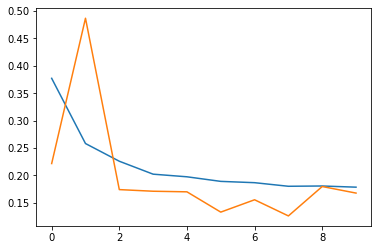

In [26]:
loss = statistics.history['loss']
val_loss = statistics.history['val_loss']
num_epochs = np.arange(10)
plt.plot(num_epochs, loss,val_loss)
#plt.plot(num_epochs, loss)

> blue = training loss
>
> orange = val loss 

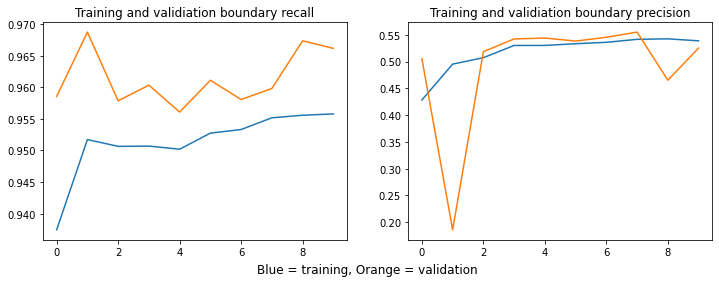

In [44]:
bound_recall = statistics.history['boundary_recall']
val_bound_recall = statistics.history['val_boundary_recall']
bound_precision = statistics.history['boundary_precision']
val_bound_precision = statistics.history['val_boundary_precision']
plt.figure(figsize=(12,4))
plt.figtext(0.5, 0.01, "Blue = training, Orange = validation", wrap=True, horizontalalignment='center', fontsize=12)
plt.subplot(121)
plt.title("Training and validiation boundary recall")
plt.plot(num_epochs, bound_recall,val_bound_recall)
plt.subplot(122)
plt.title("Training and validiation boundary precision")
plt.plot(num_epochs, bound_precision,val_bound_precision)
